In [1]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
import math
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder


from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder


from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.clustering import KMeans

from pyspark.ml.classification import RandomForestClassifier

In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

## A. Read in data and join the tables of weather, trip and station

In [3]:
%matplotlib inline

import pandas as pd 
import numpy as np

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics

import matplotlib.pyplot as plt

In [4]:
file1= 'station.csv'
file2= 'status.csv'
file3= 'trip.csv'
file4= 'weather.csv'

In [3]:
stationDtype = {
    'id': 'int32',
    'name':'object',
    'lat':'float32',
    'long':'float32',
    'dock_count':'float32',
    'city':'object'}

In [4]:
stationRaw = pd.read_csv(file1, parse_dates=['installation_date'], dtype=stationDtype)

In [5]:
stationRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 7 columns):
id                   70 non-null int32
name                 70 non-null object
lat                  70 non-null float32
long                 70 non-null float32
dock_count           70 non-null float32
city                 70 non-null object
installation_date    70 non-null datetime64[ns]
dtypes: datetime64[ns](1), float32(3), int32(1), object(2)
memory usage: 2.8+ KB


In [12]:
import zipcode

In [6]:
statusDtype = {
    'station_id':'int32',
    'bikes_available':'int32', 
    'docks_available':'int32'}

In [10]:
#statusRaw = pd.read_csv(file2, parse_dates=['time'], dtype=statusDtype)

In [11]:
#statusRaw.head()

In [12]:
#statusRaw.dtypes

In [7]:
tripDtype = {
    'id':'int32',
    'duration':'int32', 
    'start_station_name':'object',
    'end_station_name':'object',
    'end_station_id':'int32',
    'bike_id':'int32',
    'subscription_type': 'object',
    'zip_code': 'str'}

In [8]:
tripRaw = pd.read_csv(file3, parse_dates=['start_date', 'end_date'], na_values=['NaN'], dtype=tripDtype)

In [9]:
tripRaw.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,2013-08-29 14:42:00,San Jose City Hall,10,2013-08-29 14:43:00,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,2013-08-29 10:16:00,Mountain View City Hall,27,2013-08-29 10:17:00,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,2013-08-29 11:29:00,San Jose City Hall,10,2013-08-29 11:30:00,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103


In [10]:
type(tripRaw['zip_code'][0])

str

In [11]:
weatherDtype = {'zip_code': 'str'}

In [12]:
weatherRaw = pd.read_csv(file4, parse_dates=['date'],dtype=weatherDtype)

In [13]:
type(weatherRaw['zip_code'][0])

str

In [14]:
weatherRaw.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [15]:
# avg demand and total demand by weather

weather = weatherRaw[['date', 'events', 'zip_code']]
trip = tripRaw[['start_date','id', 'zip_code']]

In [16]:
weather.dtypes

date        datetime64[ns]
events              object
zip_code            object
dtype: object

In [17]:
trip.dtypes

start_date    datetime64[ns]
id                     int32
zip_code              object
dtype: object

In [19]:
trip['start_date'] = trip['start_date'].dt.floor('d')

/Users/Yimei/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
weather = weatherRaw[['date', 'events', 'zip_code']]
weather['events'] = weather['events'].fillna('Sunny')
trip = tripRaw[['start_date','id', 'zip_code']]

/Users/Yimei/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
weatherTrip = weather.merge(trip,how='left', left_on = ['date', 'zip_code'], right_on = ['start_date', 'zip_code'])

In [22]:
weatherTrip['events'] = weatherTrip['events']
weatherTrip = weatherTrip.groupby([weatherTrip['events']]).count()

In [23]:
d = {'Total Trips': weatherTrip['date']}

In [24]:
total_trip = pd.DataFrame(data=d)

In [25]:
total_trip.index.names = ['Weather Condition']

In [26]:
total_trip

,Total Trips
Weather Condition,
Fog,112
Fog-Rain,17
Rain,388
Rain-Thunderstorm,3
Sunny,3145
rain,2


### A.1.Simple EDA of the trip table

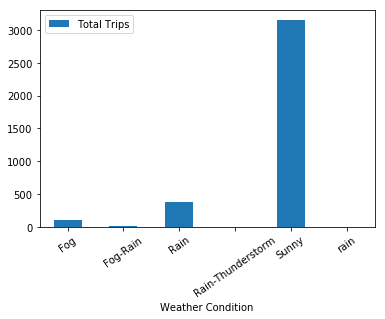

In [27]:
plt.figure()
total_trip.plot(kind='bar', rot=35)


In [47]:
# Final DataFrame 
#1. group trip by 'date' and 'id'
tripRaw['start_date'] = tripRaw['start_date'].dt.floor('d')

In [35]:
tripRaw.columns

Index([u'id', u'duration', u'start_date', u'start_station_name',
       u'start_station_id', u'end_date', u'end_station_name',
       u'end_station_id', u'bike_id', u'subscription_type', u'zip_code'],
      dtype='object')

In [36]:
tripAgg = tripRaw.groupby(['start_date','zip_code', 'start_station_name'], as_index=False)['id'].count()

In [37]:
tripAgg=tripAgg.rename(columns={'id': "num_trips"})

In [38]:
tripAgg.head()

,start_date,zip_code,start_station_name,num_trips
0,2013-08-29,10003,California Ave Caltrain Station,2
1,2013-08-29,10003,University and Emerson,2
2,2013-08-29,10009,Commercial at Montgomery,1
3,2013-08-29,10009,Mechanics Plaza (Market at Battery),1
4,2013-08-29,10009,South Van Ness at Market,1


In [43]:
weatherRaw.dtypes

date                              datetime64[ns]
max_temperature_f                        float64
mean_temperature_f                       float64
min_temperature_f                        float64
max_dew_point_f                          float64
mean_dew_point_f                         float64
min_dew_point_f                          float64
max_humidity                             float64
mean_humidity                            float64
min_humidity                             float64
max_sea_level_pressure_inches            float64
mean_sea_level_pressure_inches           float64
min_sea_level_pressure_inches            float64
max_visibility_miles                     float64
mean_visibility_miles                    float64
min_visibility_miles                     float64
max_wind_Speed_mph                       float64
mean_wind_speed_mph                      float64
max_gust_speed_mph                       float64
precipitation_inches                      object
cloud_cover         

In [44]:
weatherRaw.groupby(['zip_code'],as_index=False).count()

,zip_code,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,...,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees
0,94041,733,730,730,730,730,730,730,730,730,...,733,733,733,733,733,724,733,733,733,733
1,94063,733,733,733,733,733,733,733,733,733,...,733,733,733,733,733,321,733,733,733,733
2,94107,733,733,733,733,733,733,733,733,733,...,733,733,733,733,733,720,733,733,733,733
3,94301,733,732,732,732,682,682,682,682,682,...,720,720,720,732,732,280,732,732,733,732
4,95113,733,733,733,733,733,733,733,733,733,...,733,733,733,733,733,721,733,733,733,733


In [45]:
#tripAgg['zip_code'].unique()

In [46]:
#tripAgg['zip_code'] = tripAgg['zip_code'].astype('str')
#mask = (tripAgg['zip_code'].str.len() == 5)
#tripAgg = tripAgg.loc[mask]

In [47]:
#tripAgg['zip_code'].unique()

In [48]:
#tripAgg['start_date'] = tripAgg['start_date'].astype('object')
#weatherRaw['date'] = weatherRaw['date'].astype('object')

In [49]:
type(tripAgg['zip_code'][0])

str

In [55]:
stationRaw = stationRaw.rename(columns={'id':'station_id'})

In [ ]:
tripWeatherAgg = tripAgg.merge(weatherRaw,how='inner', left_on = ['start_date', 'zip_code'], right_on = ['date', 'zip_code'])

### A.2 Join Station

In [59]:
tripWeatherStationAgg = tripWeatherAgg.merge(stationRaw, how='left',left_on=['start_station_name'], right_on=['name'])

In [62]:
tripWeatherStationAgg.to_csv('bikeFinalDF1.csv')

In [63]:
tripWeatherStationAgg = pd.read_csv('bikeFinalDF1.csv')

In [64]:
tripWeatherStationAgg.head()

,Unnamed: 0,start_date,zip_code,start_station_name,num_trips,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,...,cloud_cover,events,wind_dir_degrees,station_id,name,lat,long,dock_count,city,installation_date
0,0,2013-08-29,94041,Mountain View Caltrain Station,1,2013-08-29,80.0,70.0,64.0,65.0,...,4.0,Sunny,355.0,28.0,Mountain View Caltrain Station,37.394360,-122.076714,23.0,Mountain View,2013-08-15
1,1,2013-08-29,94041,Mountain View City Hall,1,2013-08-29,80.0,70.0,64.0,65.0,...,4.0,Sunny,355.0,27.0,Mountain View City Hall,37.389217,-122.081894,15.0,Mountain View,2013-08-16
2,2,2013-08-29,94041,Redwood City Caltrain Station,1,2013-08-29,80.0,70.0,64.0,65.0,...,4.0,Sunny,355.0,22.0,Redwood City Caltrain Station,37.486076,-122.232086,25.0,Redwood City,2013-08-15
3,3,2013-08-29,94041,Redwood City Medical Center,1,2013-08-29,80.0,70.0,64.0,65.0,...,4.0,Sunny,355.0,26.0,Redwood City Medical Center,37.487682,-122.223495,15.0,Redwood City,2013-08-12
4,4,2013-08-29,94041,San Pedro Square,1,2013-08-29,80.0,70.0,64.0,65.0,...,4.0,Sunny,355.0,6.0,San Pedro Square,37.336720,-121.894073,15.0,San Jose,2013-08-07


## B. Add Holidays

In [65]:
import holidays
us_holidays = holidays.UnitedStates()
def holiday(date):
   if date in us_holidays:
       return 1
   else:
       return 0
tripWeatherStationAgg["holidays"] = [holiday(x) for x in list(tripWeatherStationAgg["start_date"])]

In [66]:
finalDF = tripWeatherStationAgg

In [67]:
finalDF.head()

,Unnamed: 0,start_date,zip_code,start_station_name,num_trips,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,...,events,wind_dir_degrees,station_id,name,lat,long,dock_count,city,installation_date,holidays
0,0,2013-08-29,94041,Mountain View Caltrain Station,1,2013-08-29,80.0,70.0,64.0,65.0,...,Sunny,355.0,28.0,Mountain View Caltrain Station,37.394360,-122.076714,23.0,Mountain View,2013-08-15,0
1,1,2013-08-29,94041,Mountain View City Hall,1,2013-08-29,80.0,70.0,64.0,65.0,...,Sunny,355.0,27.0,Mountain View City Hall,37.389217,-122.081894,15.0,Mountain View,2013-08-16,0
2,2,2013-08-29,94041,Redwood City Caltrain Station,1,2013-08-29,80.0,70.0,64.0,65.0,...,Sunny,355.0,22.0,Redwood City Caltrain Station,37.486076,-122.232086,25.0,Redwood City,2013-08-15,0
3,3,2013-08-29,94041,Redwood City Medical Center,1,2013-08-29,80.0,70.0,64.0,65.0,...,Sunny,355.0,26.0,Redwood City Medical Center,37.487682,-122.223495,15.0,Redwood City,2013-08-12,0
4,4,2013-08-29,94041,San Pedro Square,1,2013-08-29,80.0,70.0,64.0,65.0,...,Sunny,355.0,6.0,San Pedro Square,37.336720,-121.894073,15.0,San Jose,2013-08-07,0


In [68]:
finalDF['date'] = pd.to_datetime(finalDF['date'])
finalDF['day_of_week'] = finalDF['date'].dt.dayofweek

In [69]:
finalDF.head()

,Unnamed: 0,start_date,zip_code,start_station_name,num_trips,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,...,wind_dir_degrees,station_id,name,lat,long,dock_count,city,installation_date,holidays,day_of_week
0,0,2013-08-29,94041,Mountain View Caltrain Station,1,2013-08-29,80.0,70.0,64.0,65.0,...,355.0,28.0,Mountain View Caltrain Station,37.394360,-122.076714,23.0,Mountain View,2013-08-15,0,3
1,1,2013-08-29,94041,Mountain View City Hall,1,2013-08-29,80.0,70.0,64.0,65.0,...,355.0,27.0,Mountain View City Hall,37.389217,-122.081894,15.0,Mountain View,2013-08-16,0,3
2,2,2013-08-29,94041,Redwood City Caltrain Station,1,2013-08-29,80.0,70.0,64.0,65.0,...,355.0,22.0,Redwood City Caltrain Station,37.486076,-122.232086,25.0,Redwood City,2013-08-15,0,3
3,3,2013-08-29,94041,Redwood City Medical Center,1,2013-08-29,80.0,70.0,64.0,65.0,...,355.0,26.0,Redwood City Medical Center,37.487682,-122.223495,15.0,Redwood City,2013-08-12,0,3
4,4,2013-08-29,94041,San Pedro Square,1,2013-08-29,80.0,70.0,64.0,65.0,...,355.0,6.0,San Pedro Square,37.336720,-121.894073,15.0,San Jose,2013-08-07,0,3


In [71]:
finalDF.drop(['Unnamed: 0', 'start_date', 'name'], axis=1, inplace=True)

In [72]:
y = finalDF['num_trips']
finalDF = finalDF.drop(['num_trips'], axis=1)

In [73]:
finalDF['label'] = y

In [74]:
finalDF.head()

,zip_code,start_station_name,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,...,wind_dir_degrees,station_id,lat,long,dock_count,city,installation_date,holidays,day_of_week,label
0,94041,Mountain View Caltrain Station,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,355.0,28.0,37.394360,-122.076714,23.0,Mountain View,2013-08-15,0,3,1
1,94041,Mountain View City Hall,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,355.0,27.0,37.389217,-122.081894,15.0,Mountain View,2013-08-16,0,3,1
2,94041,Redwood City Caltrain Station,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,355.0,22.0,37.486076,-122.232086,25.0,Redwood City,2013-08-15,0,3,1
3,94041,Redwood City Medical Center,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,355.0,26.0,37.487682,-122.223495,15.0,Redwood City,2013-08-12,0,3,1
4,94041,San Pedro Square,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,355.0,6.0,37.336720,-121.894073,15.0,San Jose,2013-08-07,0,3,1


In [75]:
finalDF.to_csv('bikeDF2.csv')

In [76]:
#reconstruct the schema
schema = StructType([
    StructField('unnamed', IntegerType(), True),
    StructField("zip_code",IntegerType(),True),
    StructField("start_station_name",StringType(),True),
    StructField("date",DateType(),True),
    StructField("max_temperature_f",FloatType(),True),
    StructField("mean_temperature_f",FloatType(),True),
    StructField("min_temperature_f",FloatType(),True),
    StructField("max_dew_point_f",FloatType(),True),
    StructField("mean_dew_point_f",FloatType(),True),
    StructField("min_dew_point_f",FloatType(),True),
    StructField("max_humidity",FloatType(),True),
    StructField("mean_humidity",FloatType(),True),
    StructField("min_humidity",FloatType(),True),
    StructField("max_sea_level_pressure_inches",FloatType(),True),
    StructField("mean_sea_level_pressure_inches",FloatType(),True),
    StructField("min_sea_level_pressure_inches",FloatType(),True),
    StructField("max_visibility_miles",FloatType(),True),
    StructField("mean_visibility_miles",FloatType(),True),
    StructField("min_visibility_miles",FloatType(),True),
    StructField("max_wind_Speed_mph",FloatType(),True),
    StructField("mean_wind_speed_mph",FloatType(),True),
    StructField("max_gust_speed_mph",FloatType(),True),
    StructField("precipitation_inches",FloatType(),True),
    StructField("cloud_cover",FloatType(),True),
    StructField("events",StringType(),True),
    StructField("wind_dir_degrees",FloatType(),True),
    StructField("station_id",FloatType(),True),
    StructField("lat",FloatType(),True),
    StructField("long",FloatType(),True),
    StructField("dock_count",IntegerType(),True),
    StructField("city",StringType(),True),
    StructField("installation_date",DateType(),True),
    StructField("holidays",IntegerType(),True),
    StructField("day_of_week",IntegerType(),True),
    StructField("label",IntegerType(),True)
])

## C. modeling

In [ ]:

df = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='true') \
    .load('bikeDF2.csv', schema = schema)

In [78]:
df.show(1)

+-------+--------+------------------+----+-----------------+------------------+-----------------+---------------+----------------+---------------+------------+-------------+------------+-----------------------------+------------------------------+-----------------------------+--------------------+---------------------+--------------------+------------------+-------------------+------------------+--------------------+-----------+------+----------------+----------+----+----+----------+----+-----------------+--------+-----------+-----+
|unnamed|zip_code|start_station_name|date|max_temperature_f|mean_temperature_f|min_temperature_f|max_dew_point_f|mean_dew_point_f|min_dew_point_f|max_humidity|mean_humidity|min_humidity|max_sea_level_pressure_inches|mean_sea_level_pressure_inches|min_sea_level_pressure_inches|max_visibility_miles|mean_visibility_miles|min_visibility_miles|max_wind_Speed_mph|mean_wind_speed_mph|max_gust_speed_mph|precipitation_inches|cloud_cover|events|wind_dir_degrees|stati

In [132]:
df = df.drop('unnamed', 'date', 'installation_date', 'city')

In [133]:
df.show(3)

+--------+--------------------+-----------------+------------------+-----------------+---------------+----------------+---------------+------------+-------------+------------+-----------------------------+------------------------------+-----------------------------+--------------------+---------------------+--------------------+------------------+-------------------+------------------+--------------------+-----------+------+----------------+----------+---------+-----------+----------+--------+-----------+-----+
|zip_code|  start_station_name|max_temperature_f|mean_temperature_f|min_temperature_f|max_dew_point_f|mean_dew_point_f|min_dew_point_f|max_humidity|mean_humidity|min_humidity|max_sea_level_pressure_inches|mean_sea_level_pressure_inches|min_sea_level_pressure_inches|max_visibility_miles|mean_visibility_miles|min_visibility_miles|max_wind_Speed_mph|mean_wind_speed_mph|max_gust_speed_mph|precipitation_inches|cloud_cover|events|wind_dir_degrees|station_id|      lat|       long|dock_

In [150]:
df = df.na.drop()

In [151]:
#converting strings to numeric values
from pyspark.ml.feature import StringIndexer

def indexStringColumns(df, cols):
    #variable newdf will be updated several times
    newdf = df
    
    for c in cols:
        #For each given colum, fits StringIndexerModel.
        si = StringIndexer(inputCol=c, outputCol=c+"-num")
        sm = si.fit(newdf)
        #Creates a DataFame by putting the transformed values in the new colum with suffix "-num" 
        #and then drops the original columns.
        #and drop the "-num" suffix. 
        newdf = sm.transform(newdf).drop(c)
        newdf = newdf.withColumnRenamed(c+"-num", c)
    return newdf

dfnumeric = indexStringColumns(df,['start_station_name', 'events', 'dock_count'])

In [152]:
dfnumeric.show(3)

+--------+-----------------+------------------+-----------------+---------------+----------------+---------------+------------+-------------+------------+-----------------------------+------------------------------+-----------------------------+--------------------+---------------------+--------------------+------------------+-------------------+------------------+--------------------+-----------+----------------+----------+---------+-----------+--------+-----------+-----+------------------+------+----------+
|zip_code|max_temperature_f|mean_temperature_f|min_temperature_f|max_dew_point_f|mean_dew_point_f|min_dew_point_f|max_humidity|mean_humidity|min_humidity|max_sea_level_pressure_inches|mean_sea_level_pressure_inches|min_sea_level_pressure_inches|max_visibility_miles|mean_visibility_miles|min_visibility_miles|max_wind_Speed_mph|mean_wind_speed_mph|max_gust_speed_mph|precipitation_inches|cloud_cover|wind_dir_degrees|station_id|      lat|       long|holidays|day_of_week|label|start_st

In [153]:
dfnumeric

DataFrame[zip_code: int, max_temperature_f: float, mean_temperature_f: float, min_temperature_f: float, max_dew_point_f: float, mean_dew_point_f: float, min_dew_point_f: float, max_humidity: float, mean_humidity: float, min_humidity: float, max_sea_level_pressure_inches: float, mean_sea_level_pressure_inches: float, min_sea_level_pressure_inches: float, max_visibility_miles: float, mean_visibility_miles: float, min_visibility_miles: float, max_wind_Speed_mph: float, mean_wind_speed_mph: float, max_gust_speed_mph: float, precipitation_inches: float, cloud_cover: float, wind_dir_degrees: float, station_id: float, lat: float, long: float, holidays: int, day_of_week: int, label: int, start_station_name: double, events: double, dock_count: double]

In [154]:
# Merging the data with Vector Assembler.
from pyspark.ml.feature import VectorAssembler
input_cols = ['zip_code','max_temperature_f','mean_temperature_f','min_temperature_f',
        'max_dew_point_f','mean_dew_point_f','min_dew_point_f','max_humidity','mean_humidity',
        'min_humidity','max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
        'min_sea_level_pressure_inches', 'max_visibility_miles','mean_visibility_miles',
        'min_visibility_miles', 'max_wind_Speed_mph', 'mean_wind_speed_mph',
        'max_gust_speed_mph','precipitation_inches','cloud_cover','wind_dir_degrees',
        'station_id', 'lat','long','holidays','day_of_week','start_station_name',
        'events','dock_count']

#VectorAssembler takes a number of collumn names(inputCols) and output column name (outputCol)
#and transforms a DataFrame to assemble the values in inputCols into one single vector with outputCol.
va = VectorAssembler(outputCol="features", inputCols=input_cols)
#lpoints - labeled data.
df_final = va.transform(dfnumeric).select("features", "label")

In [155]:
dfSets = df_final.randomSplit([0.8, 0.2], 1)
dfTrain = dfSets[0].cache()
dfTest = dfSets[1].cache()

In [159]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(maxDepth=20, maxBins=70)
rfmodel = rf.fit(dfTrain)

In [161]:
from pyspark.ml.evaluation import RegressionEvaluator
rfpredicts = rfmodel.transform(dfTest)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(rfpredicts)
print("RMSE = %d" % rmse)

RMSE = 1
